In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import random
import corner
from getdist import plots, MCSamples
import getdist
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True
from scipy.stats import distributions


GetDist Version: 1.1.2, Matplotlib version: 3.3.1


In [2]:
#introducción de los datos
#N es la cantidad de datos, NN el número de iteraciones para el programa caminante
#definición de av y bv para guardar los parámetros que cumplen la regla de selección
#av[0] y bv[0] son los parametros iniciales dados por uno, cv, y la creación de otras listas es para 
#parametros de otros modelos
#x1 y y1 son los datos 
NN=10000
dt=np.load('fit_exercise.npy')
x1 = dt[0]
y1 = dt[1]
yerr=dt[2]
N=len(x1)
v=0.1
av=np.zeros(NN)
bv=np.zeros(NN)

In [3]:
#linear least square
A = np.vstack([dt[0], np.ones(len(dt[0]))]).T
b, a = np.linalg.lstsq(A, dt[1], rcond=None)[0]
print(a, b)

4.57785930375336 -0.9821623517930427


In [4]:
def modelo(a, b):
        mod = a + (b*x1)
        return mod

In [5]:
#Usando el likelihood en la documentación
def ls(a, b):
    mu = modelo(a, b)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y1 - mu) ** 2 / sigma2 + np.log(sigma2))

In [6]:
def prior(a, b):
    if -10<a<10 and -10<b<10:
        return 0
    return -np.inf

In [7]:
def MCM3(p1, p2):
    accepteda = []
    acceptedb = []
    rejecteda = [] 
    rejectedb = []   
    av[0]=p1
    bv[0]=p2
    for k in range(NN-1):
        ak = np.random.normal(av[k], v)
        bk = np.random.normal(bv[k], v)
        posteriorold = ls(av[k], bv[k]) + prior(av[k], bv[k])
        posteriornew = ls(ak, bk) + prior(ak, bk)
        ratio = posteriornew-posteriorold
        ran = math.log(random.uniform(0, 1))
    #print(ratio, ran)
        if ratio > 0:
            accepteda.append(ak)
            acceptedb.append(bk)
            av[k+1] = ak
            bv[k+1] = bk
        else:
            if ratio > ran:
                accepteda.append(ak)
                acceptedb.append(bk)
                av[k+1] = ak
                bv[k+1] = bk
            else:
                rejecteda.append(ak)
                rejectedb.append(bk)
                av[k+1] = np.copy(av[k])
                bv[k+1] = np.copy(bv[k])  
    ta=np.array(accepteda)
    #tb=np.array(acceptedb)
    #ra=np.array(rejecteda)
    #rb=np.array(rejectedb)
    porc_a=(len(ta)/NN)
    #porc_b=(len(tb)/NN)
    return av, bv, porc_a
    #return print('el parámetro a es', av.mean()), print('el parámetro b es', bv.mean(), porc_a)

In [8]:
MCM3(4, -0.7)

(array([4.        , 4.02123371, 4.15040705, ..., 5.46129855, 5.4648255 ,
        5.4648255 ]),
 array([-0.7       , -0.8095601 , -0.96595748, ..., -1.11009814,
        -1.10250383, -1.10250383]),
 0.0678)

## Multiples caminadores

In [9]:
def multMCM(arr):
    s1 = np.zeros((5, NN))
    s2 = np.zeros((5, NN))
    porca = np.zeros(5)
    porcb = np.zeros(5)
    for k in range(5):
        s1[k], s2[k], porca[k]=np.copy(MCM3(arr[k][0], arr[k][1]))
    return s1, s2, porca

In [10]:
pos=np.array([4.57785930375336, -0.9821623517930427])

In [11]:
#usando el arreglo como en la documentación de emcee en vez de l y g
pos = pos + 1e-4 * np.random.randn(5, 2)
nwalkers, ndim = pos.shape


In [12]:
g=np.array([-1.2, -1.3, -1.2, -1.1, -1.4])
l=np.array([4.4, 4.3, 4.1, 4.6, 4.8])

In [13]:
#se obtienen las cadenas y la aceptación en arreglos
s1, s2, pa = multMCM(pos)

C:\Users\ana__\miniconda3\envs\hola\lib\site-packages\numpy\lib\function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [14]:
pa

array([0.0685, 0.0663, 0.0623, 0.0659, 0.0609])

## Análisis cuantitativo de cadenas

Recordando en este caso tenemos 5 caminantes

In [15]:
print("Tasa de aceptación:")
print("promedio aceptación = {0:.3f}".format(pa.mean()))
print("media de caminantes en a = {0:.3f}".format(s1.mean()))
print("varianza de caminantes en a = {0:.3f}".format(s1.var()))
print("media de caminantes en b = {0:.3f}".format(s2.mean()))
print("varianza de caminantes en b = {0:.3f}".format(s2.var()))

Tasa de aceptación:
promedio aceptación = 0.065
media de caminantes en a = 5.433
varianza de caminantes en a = 0.012
media de caminantes en b = -1.103
varianza de caminantes en b = 0.000


la aceptación es muy pequeña, más adelante usare una sigma con la cual aumenta la aceptación pero de acuerdo a lo señalado de tomar una sigma una unidad menos que los parámetros no es lo adecuado. En este caso usé sigma 0.1 y usando emcee se obtienen valores muy cercanos.

In [16]:
#para el diagnóstico de Gelman-Rubin guardamos las medias de los caminantes por parámetro en un arreglo
muv=np.zeros(2)
muv[0]=s1.mean()
muv[1]=s2.mean()

## Gráficas de variación de parámetros por iteraciones

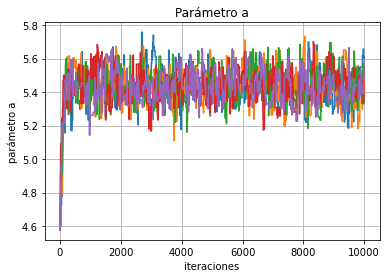

In [17]:
for i in range(5):
    plt.plot(np.arange(NN), s1[i])
plt.title(label='Parámetro a')
plt.xlabel('iteraciones')
plt.ylabel('parámetro a')
plt.grid()

Text(0, 0.5, 'parámetro b')

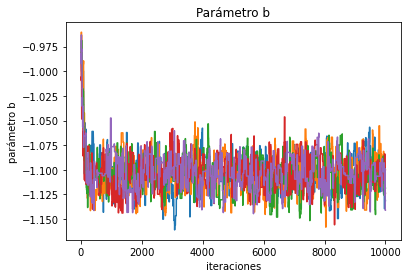

In [18]:
for i in range(5):
    plt.plot(np.arange(NN), s2[i])
plt.title(label='Parámetro b')
plt.xlabel('iteraciones')
plt.ylabel('parámetro b')

## Gráficas triangulares

### Definición de samples para uso en getdist

In [19]:
samps=np.array([s1[0].T, s2[0].T]).T

In [20]:
samps2=np.array([s1[1].T, s2[1].T]).T

In [21]:
samps3=np.array([s1[2].T, s2[2].T]).T

In [22]:
samps4=np.array([s1[3].T, s2[3].T]).T

In [23]:
samps5=np.array([s1[4].T, s2[4].T]).T

In [24]:
#arreglo que guarda todas las cadenas para usar después en math display
allsamples=np.vstack([samps, samps2, samps3, samps4, samps5])

In [25]:
ndim = 2
nsamp = NN

In [26]:
names = ['a0', 'b0']
labels =  ['a', 'b']
samples = MCSamples(samples=samps,names = names, labels = labels, label='first set')
samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')
samples3 = MCSamples(samples=samps3,names = names, labels = labels, label='Second set')
samples4 = MCSamples(samples=samps4,names = names, labels = labels, label='Second set')
samples5 = MCSamples(samples=samps5,names = names, labels = labels, label='Second set')


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


## Gráfica triangular con primer sigma

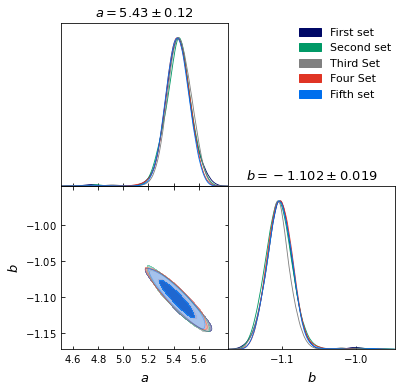

In [27]:
#### Triangle plot 
g = plots.get_subplot_plotter(width_inch=6)
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=1)
#, param_limits={'a0': (4, 5), 'b0': (-0.5, -1.5)}
#  title limit same to 1 (for 1D plots) is 68% by default

## Gráfica triangular con segundo sigma

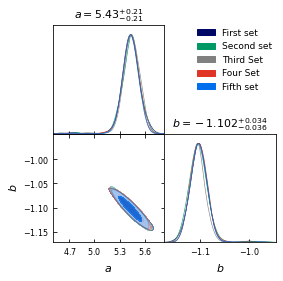

In [28]:
# Triangle plot 
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, 
                legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], 
                legend_loc='upper right',
                title_limit=2)
#  title limit 2

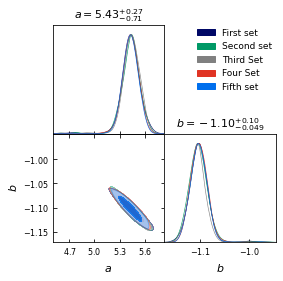

In [29]:
# Triangle plot 
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=3)
#  title limit 3

## Diagnóstico de Gelman-Rubin

$\hat{\mu} $ promedio de la muestra de los mn valores simulados de x, $\hat{\mu} $=$\bar{x}$

In [30]:
#uní los arreglos para los calculos
s=np.array([s1, s2])

Para 
$$s_{i}^{2}=\frac{1}{n-1}\sum_{t=1}^{n}(X_{it}-\bar{X_{i}})$$

donde:

$\bar{X_{i}}$ es la media por cadena i (para un parámetro dado)

$s_{i}$ Varianza para una cadena i

In [31]:
sksq=np.zeros([2,5])
for k in range(2):
    for i in range(5):
        gr1=0
        for j in range(N):
            gr=(s[k][i][j]-s[k][i].mean())**2
            gr1=gr1+gr    
        sksq[k][i]=gr1/(N-1)

Calculo del promedio de las m varianzas, $s_{i}^{2}$, cada una dividida entre n-1 grados de libertad en la celda anterior

$$s^{2}=\frac{1}{m}\sum_{i=1}^{m}s_{i}^{2}$$

con n los valores en la cadena, m las cadenas, $\hat{\mu}$ promedio para un parámetro dado

In [32]:
ssq=np.zeros(2)
for i in range(2):
    ssq[i]=(np.sum(sksq[i]))/5

Cálculo de B/n la varianza entre las m secuencias de media, $\bar{x_{i}}$, cada una en base de los n valores de x

$$\frac{B}{n}=\frac{1}{m-1}\sum_{i=1}^{m}(\bar{X_{i}}-\hat{\mu})^{2}$$

In [33]:
sum=0
Bn=np.zeros(2)
for k in range(2):
    for i in range(5):
        dd=((s[k][i].mean()-muv[k])**2)
        sum=sum+dd
    Bn[k]=sum/4

para la varianza $\hat{\sigma^{2}}$

$$\hat{\sigma^{2}}=\frac{n-1}{n}s^{2}+\frac{B}{n}$$

In [34]:
varsq=np.zeros(2)
for k in range(2):
    varsq[k]=(N-1)*ssq[k]*(N**(-1))+Bn[k]

Calculando $\hat{R}$ con $\hat{R}\leq\delta$ para una $\delta \geq 1$ la cadena puede haber convergido

In [35]:
R=np.zeros(2)
for i in range(2):
    R[i]=math.sqrt(varsq[i]/ssq[i])

In [36]:
R

array([0.9899785 , 0.99119827])

## Comparando con emcee

In [37]:
def posterior(theta, x, y, yerr):
    a, b=theta
    post=ls(a, b) +prior(a, b)
    return post

pos=np.array([4, -0.7])

In [38]:
import emcee

In [39]:
#pos = pos + 1e-4 * np.random.randn(5, 2)
#nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(x1, y1, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1086.26it/s]


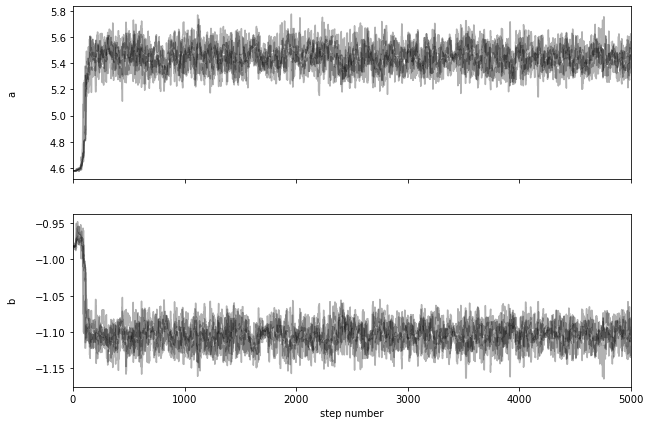

In [40]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [41]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

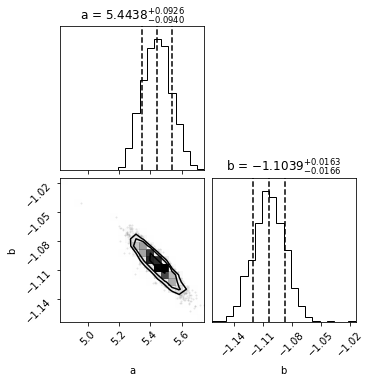

In [42]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.50, 0.84], title_fmt='.4f', show_titles=True
);

In [43]:
from IPython.display import display, Math
print("Valores con emcee:")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Valores con emcee:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [44]:
from IPython.display import display, Math
print("Valores con MCM:")
for i in range(ndim):
    mcmc = np.percentile(allsamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Valores con MCM:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Cambiando la varianza donde hay mayor aceptación 

In [45]:
v=0.01

In [46]:
s1, s2, pa = multMCM(pos)

C:\Users\ana__\miniconda3\envs\hola\lib\site-packages\numpy\lib\function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [47]:
print("Tasa de aceptación:")
print("promedio aceptación = {0:.3f}".format(pa.mean()))
print("media de caminantes en a = {0:.3f}".format(s1.mean()))
print("varianza de caminantes en a = {0:.3f}".format(s1.var()))
print("media de caminantes en b = {0:.3f}".format(s2.mean()))
print("varianza de caminantes en b = {0:.3f}".format(s2.var()))

Tasa de aceptación:
promedio aceptación = 0.573
media de caminantes en a = 5.407
varianza de caminantes en a = 0.023
media de caminantes en b = -1.099
varianza de caminantes en b = 0.001


In [48]:
samps=np.array([s1[0].T, s2[0].T]).T

In [49]:
samps2=np.array([s1[1].T, s2[1].T]).T

In [50]:
samps3=np.array([s1[2].T, s2[2].T]).T

In [51]:
samps4=np.array([s1[3].T, s2[3].T]).T

In [52]:
samps5=np.array([s1[4].T, s2[4].T]).T

In [53]:
#arreglo que guarda todas las cadenas
allsamples=np.vstack([samps, samps2, samps3, samps4, samps5])

In [54]:
ndim = 2
nsamp = NN

In [55]:
names = ['a0', 'b0']
labels =  ['a', 'b']
samples = MCSamples(samples=samps,names = names, labels = labels, label='first set')
samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')
samples3 = MCSamples(samples=samps3,names = names, labels = labels, label='Second set')
samples4 = MCSamples(samples=samps4,names = names, labels = labels, label='Second set')
samples5 = MCSamples(samples=samps5,names = names, labels = labels, label='Second set')


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


## Gráfica triangular con primer sigma

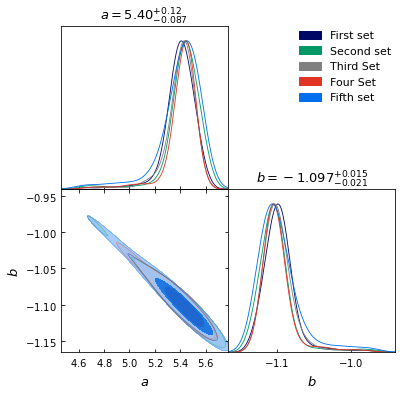

In [56]:
#### Triangle plot 
g = plots.get_subplot_plotter(width_inch=6)
g.settings.figure_legend_frame = False
g.settings.title_limit_fontsize = 14
g.triangle_plot([samples, samples2, samples3, samples4, samples5], filled=True, legend_labels = ['First set', 'Second set', 'Third Set', 'Four Set', 'Fifth set'], legend_loc='upper right',
                title_limit=1)
#, param_limits={'a0': (4, 5), 'b0': (-0.5, -1.5)}
#  title limit same to 1 (for 1D plots) is 68% by default

In [57]:
#uní los arreglos para los calculos
s=np.array([s1, s2])
sksq=np.zeros([2,5])
for k in range(2):
    for i in range(5):
        gr1=0
        for j in range(N):
            gr=(s[k][i][j]-s[k][i].mean())**2
            gr1=gr1+gr    
        sksq[k][i]=gr1/(N-1)
            
ssq=np.zeros(2)
for i in range(2):
    ssq[i]=(np.sum(sksq[i]))/5
    
sum=0
Bn=np.zeros(2)
for k in range(2):
    for i in range(5):
        dd=((s[k][i].mean()-muv[k])**2)
        sum=sum+dd
    Bn[k]=sum/4

varsq=np.zeros(2)
for k in range(2):
    varsq[k]=(N-1)*ssq[k]*(N**(-1))+Bn[k]

R=np.zeros(2)
for i in range(2):
    R[i]=math.sqrt(varsq[i]/ssq[i])

In [58]:
R

array([0.99070408, 1.01893599])

In [ ]:
para el parámetro 